<a href="https://colab.research.google.com/github/keles98/beige-apple-1ed49/blob/master/Tarea_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from datetime import datetime
#!pip install tensorflow_datasets
#!pip install tensorflow-text
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
print(tf.__version__)

2.8.0


# Tarea 3 del curso: Hello world !! con Tensorflow 2. Una Introducción a Deep Learning 

### Primera parte: Genere el pipeline para un dato predefinido en https://www.tensorflow.org/datasets/catalog/overview

In [9]:
#descargue Fashion-MNIST
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name = 'fashion_mnist', #descargue Fashion-MNIST
    split = ['train[:80%]', 'train[80%:]', 'test'], # genere 80% datos entrenados y 20% datos de validacion usando conjunto de datos entrenados. Tambien genere datos de prueba
    shuffle_files = True,
    as_supervised = True,
    with_info = True # genere informacion
    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8Q2JOI/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8Q2JOI/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


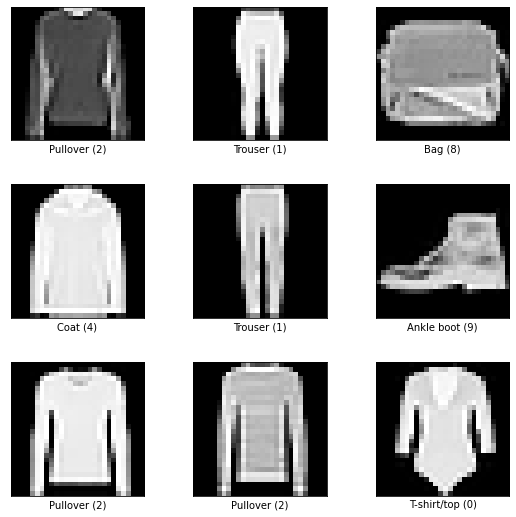

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

In [11]:
#Rotulos y sus indices
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

In [13]:
## Preprocesamiento!!
def normalize_img(image,label ):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.rot90(image) #rotar la imagen 90 grados. hint: tf.image.rot...
  return tf.cast(image, tf.float32) / 255., tf.one_hot(label,depth=10) #retorne la imagen normalizada y con el prepocesamiento anterior, tambien el label en one_hot.

## Pipeline!!
def data_load(data_ds, augmented = normalize_img, shuffle_ = True, batch_ = 5):
    data_ds = data_ds.map(augmented, num_parallel_calls = tf.data.AUTOTUNE) #complete codigo de map
    if shuffle_:
        data_ds = data_ds.shuffle(len(data_ds))
    data_ds = data_ds.batch(batch_) ## complete codigo de batches
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

In [18]:
## genere datos en  10 batches
data_train = data_load(ds_train, batch_ = 10) # complete codigo
data_test = data_load(ds_test, batch_ = 10, shuffle_=False) # complete codigo
data_validation = data_load(ds_validation, batch_ = 10, shuffle_=False) #  complete codigo

(10, 28, 28, 1) tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


TypeError: ignored

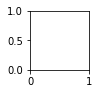

In [19]:
##imagenes de datos de entrenamiento 
plt.figure(figsize=(5, 5))
i=0
for ds,lb in data_train.take(16):
    print(ds.shape,lb)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(ds[0].numpy())
    index = tf.argmax(lb, axis=1)
    plt.title('{}'.format(fashion_mnist_labels[index[0]]))
    plt.axis("off")
    i+=1

### Parte 2. Regresion Lineal 

<function matplotlib.pyplot.legend(*args, **kwargs)>

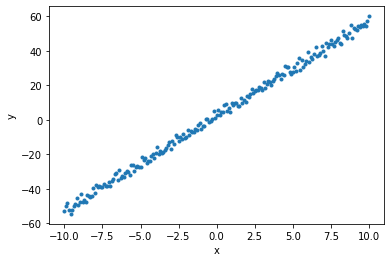

In [ ]:
##Generacion de datos
x = tf.linspace(-10.0, 10.0, 200+1)
inter_true=tf.constant(2.3)
pendi_true=tf.constant(5.5)
noise = tf.random.normal(
    (201,), mean=0.0, stddev=1.9, dtype=tf.dtypes.float32)
y = pendi_true*x+inter_true+noise
plt.scatter(x,y,marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend

In [ ]:
## Datos generados en Dataframe
dict_={'x':x,'y':y}
df =pd.DataFrame(dict_)
df.head()

,x,y
0,-10.0,-52.845455
1,-9.9,-50.041302
2,-9.8,-48.350018
3,-9.7,-52.424183
4,-9.6,-54.462551


In [ ]:
## Uso de Gradient Descent para realizar la regresion lineal #https://en.wikipedia.org/wiki/Gradient_descent

def gradient_descent(df, init_pendiente, init_intercept, n_pasos=80, learning_rate=1e-3):
    
    #datos
    x, y = df['x'].values, df['y'].values
    
    #definicion de variables pendiente m y punto de corte b
    tf_pend = tf.Variable(init_pendiente, dtype='float32', name='m') 
    tf_inter = tf.Variable(init_intercept, dtype='float32', name='b') 
    loss_hist = []
    
    #iteraciones
    for _ in range(n_pasos):
        
        # funcion with tf.GradientTape() 
        with tf.GradientTape(watch_accessed_variables=False) as tape:

            tape.watch( ##Complete codigo)

           
            predicc = tf_pend * x + tf_inter
            errors = predicc - y
            loss = tf.reduce_mean(errors**2)

        # evaluacion del gradiente dloss/dm (dl_dm) y dloss/db (dl_db)
        
        dl_dm,dl_db = tape.gradient(##Complete codigo)
        
        # gradient_descent algoritmo
        tf_pend = tf_pend - learning_rate * dl_dm
        tf_inter = tf_inter - learning_rate * dl_db 
            
        # generacion lista de valores de la funcion loss en cada iteracion
        loss_hist.append(loss.numpy())
        
        
    return tf_pend.numpy(), tf_inter.numpy(), loss_hist

In [ ]:
m_pred, b_pred, loss_func = gradient_descent(df, 2., 2.)
print('Valor de la pendiente predicha: {}. Valor de la pendiente real: {}. \n'.format(m_pred,pendi_true.numpy()))
print('Valor del intercepto predicho: {}. Valor del intercepto real: {}. \n'.format(b_pred,inter_true.numpy()))

Valor de la pendiente predicha: 5.490266799926758. Valor de la pendiente real: 5.5. 

Valor del intercepto predicho: 2.07192325592041. Valor del intercepto real: 2.299999952316284. 



<function matplotlib.pyplot.legend(*args, **kwargs)>

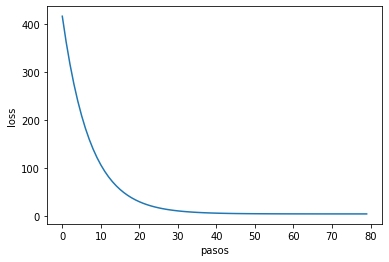

In [ ]:
## Grafica del comportamiento de la funcion loss en cada iteracion
plt.plot(loss_func)
plt.xlabel('pasos')
plt.ylabel('loss')
plt.legend

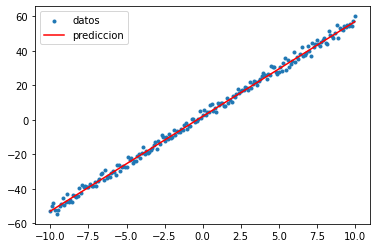

In [ ]:
# Prediccion de la regresion!
plt.scatter(x,y,marker='.', label='datos')
plt.plot(x,x*m_pred+b_pred,color='red', label='prediccion')
plt.legend()

##### Funciona!!

### Parte 3. Datos estructurados.
Escoja una base de datos estructurado de: https://www.tensorflow.org/datasets/catalog/overview#structured y genere un pipeline con un batch de 100, dividido en entrenamiento y prueba, y con propiedades de shuffle, cache, prefetch y  normalize los datos numericos. 